# Logistic Regression

In [120]:
import os
import pandas as pd
import string
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning

In [121]:
# Load data
try:
    orig_df = pd.read_csv("../Symptom2Disease.csv")
    orig_df.drop("Unnamed: 0", inplace=True, axis=1)
except Exception as e:
    raise RuntimeError("Error loading data: " + str(e))

In [122]:
# Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(sent):
    sent = sent.translate(str.maketrans('', '', string.punctuation)).strip()
    words = word_tokenize(sent)
    words = [word for word in words if word not in stop_words]
    return " ".join(words).lower()

nltk.download('punkt')
orig_df["text"] = orig_df["text"].apply(clean_text)

[nltk_data] Downloading package punkt to /Users/Arkhitech/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [123]:
# Convert labels to indices
diseases = orig_df["label"].unique()
idx2dis = {k: v for k, v in enumerate(diseases)}
dis2idx = {v: k for k, v in idx2dis.items()}
orig_df["label"] = orig_df["label"].apply(lambda x: dis2idx[x])

In [124]:
# Tokenization, Lowercasing, Lemmatization
tokens = [word_tokenize(sen) for sen in orig_df.text]
lower_tokens = [[w.lower() for w in token] for token in tokens]
lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [[lemmatizer.lemmatize(w) for w in token] for token in lower_tokens]
stoplist = stopwords.words('english')
filtered_words = [[word for word in tokens if word not in stoplist] for tokens in lemmatized_tokens]
orig_df['Text_Final'] = [' '.join(sen) for sen in filtered_words]
orig_df['tokens'] = filtered_words

# Data preparation
data = orig_df[['Text_Final', 'label']]

# Check class distribution
class_distribution = data['label'].value_counts()
print("Class Distribution:\n", class_distribution)

Class Distribution:
 0     50
1     50
22    50
21    50
20    50
19    50
18    50
17    50
16    50
15    50
14    50
13    50
12    50
11    50
10    50
9     50
8     50
7     50
6     50
5     50
4     50
3     50
2     50
23    50
Name: label, dtype: int64


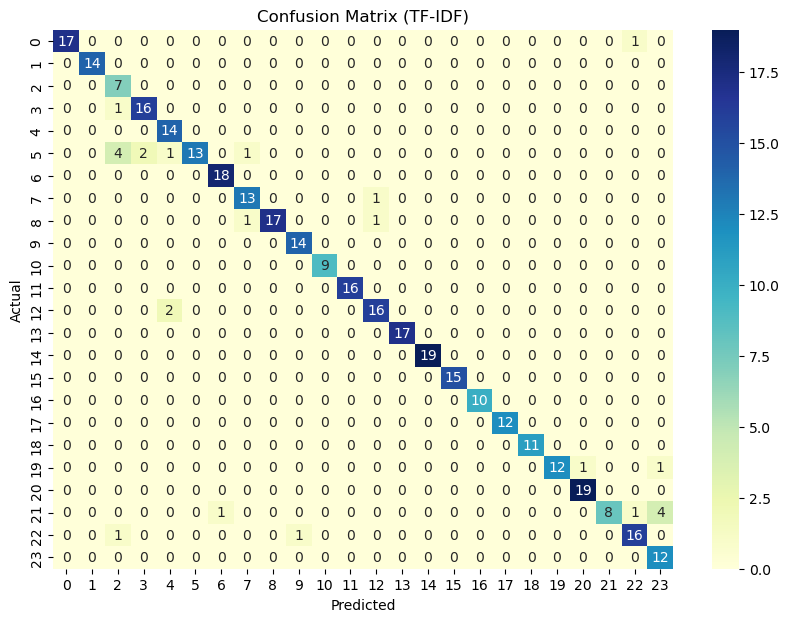

Confusion Matrix:
[[17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  2  1 13  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 17  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0

In [125]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = vectorizer.fit_transform(data.Text_Final).toarray()
labels = data.label

# Train-test split for TF-IDF
try:
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features, labels, data.index, test_size=0.3, random_state=82)
except Exception as e:
    raise RuntimeError("Error during train-test split: " + str(e))

# Logistic Regression model with TF-IDF
try:
    model = LogisticRegression(solver='liblinear')  # Using 'liblinear' solver for better convergence
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        clf = model.fit(X_train, y_train)
        for warning in w:
            print(f"Warning: {warning.message}")
    y_pred = model.predict(X_test)
except Exception as e:
    raise RuntimeError("Error during model training or prediction: " + str(e))

# Confusion Matrix and Accuracy for TF-IDF
try:
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlGnBu', xticklabels=range(len(set(labels))), yticklabels=range(len(set(labels))))
    plt.title('Confusion Matrix (TF-IDF)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print('Confusion Matrix:')
    print(conf_mat)
    print('Accuracy Score:', accuracy_score(y_test, y_pred))
except Exception as e:
    raise RuntimeError("Error during confusion matrix or accuracy score calculation: " + str(e))

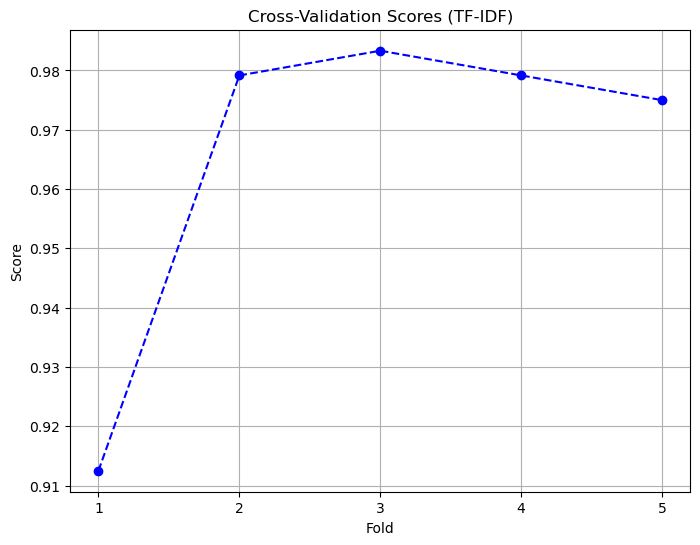

Cross-Validation Scores: [0.9125     0.97916667 0.98333333 0.97916667 0.975     ]
Mean Cross-Validation Score: 0.9658333333333333
Number of classes: 24
AUC: 0.9971158174170783
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       1.00      1.00      1.00        14
           2       0.54      1.00      0.70         7
           3       0.89      0.94      0.91        17
           4       0.82      1.00      0.90        14
           5       1.00      0.62      0.76        21
           6       0.95      1.00      0.97        18
           7       0.87      0.93      0.90        14
           8       1.00      0.89      0.94        19
           9       0.93      1.00      0.97        14
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        16
          12       0.89      0.89      0.89        18
          13       1.00      1.00      1.00 

In [126]:
# Cross-Validation for TF-IDF
try:
    scores = cross_val_score(model, features, labels, cv=5)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 6), scores, marker='o', linestyle='--', color='b')
    plt.title('Cross-Validation Scores (TF-IDF)')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.xticks(range(1, 6))
    plt.grid(True)
    plt.show()
    print("Cross-Validation Scores:", scores)
    print("Mean Cross-Validation Score:", scores.mean())
except Exception as e:
    raise RuntimeError("Error during cross-validation: " + str(e))

# ROC AUC Score for TF-IDF
try:
    unique_classes = sorted(set(y_test))
    n_classes = len(unique_classes)
    print(f"Number of classes: {n_classes}")
    if n_classes > 1:
        y_test_binarized = label_binarize(y_test, classes=unique_classes)
        y_pred_proba = model.predict_proba(X_test)
        if y_pred_proba.shape[1] != n_classes:
            y_pred_proba = y_pred_proba[:, :n_classes]
            print(f"Trimmed predicted probabilities to match number of classes. New shape: {y_pred_proba.shape}")
        print('AUC:', roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovo'))
    else:
        print(f"ROC AUC score cannot be computed since only one class {unique_classes} is present in y_true.")
except Exception as e:
    raise RuntimeError("Error during ROC AUC score calculation: " + str(e))

# Classification Report for TF-IDF
try:
    print('Classification Report:')
    print(classification_report(y_test, y_pred, zero_division=1))
except Exception as e:
    raise RuntimeError("Error during classification report generation: " + str(e))

[LibLinear]iter  1 act 4.094e+02 pre 3.626e+02 delta 1.668e+00 f 5.822e+02 |g| 6.183e+02 CG   2
cg reaches trust region boundary
iter  2 act 8.807e+01 pre 7.352e+01 delta 2.241e+00 f 1.728e+02 |g| 1.430e+02 CG   3
cg reaches trust region boundary
iter  3 act 4.043e+01 pre 3.374e+01 delta 2.818e+00 f 8.475e+01 |g| 6.259e+01 CG   4
iter  4 act 8.251e+00 pre 7.009e+00 delta 2.818e+00 f 4.432e+01 |g| 2.228e+01 CG   4
iter  5 act 1.315e+00 pre 1.122e+00 delta 2.818e+00 f 3.607e+01 |g| 7.060e+00 CG   3
iter  6 act 1.850e-01 pre 1.739e-01 delta 2.818e+00 f 3.475e+01 |g| 1.721e+00 CG   4
iter  7 act 5.603e-03 pre 5.565e-03 delta 2.818e+00 f 3.457e+01 |g| 2.257e-01 CG   4
iter  8 act 8.054e-05 pre 8.051e-05 delta 2.818e+00 f 3.456e+01 |g| 2.215e-02 CG   6
iter  9 act 1.156e-07 pre 1.156e-07 delta 2.818e+00 f 3.456e+01 |g| 7.327e-04 CG   5
iter  1 act 4.249e+02 pre 3.756e+02 delta 1.733e+00 f 5.822e+02 |g| 6.288e+02 CG   2
cg reaches trust region boundary
iter  2 act 9.384e+01 pre 7.920e+01 delt

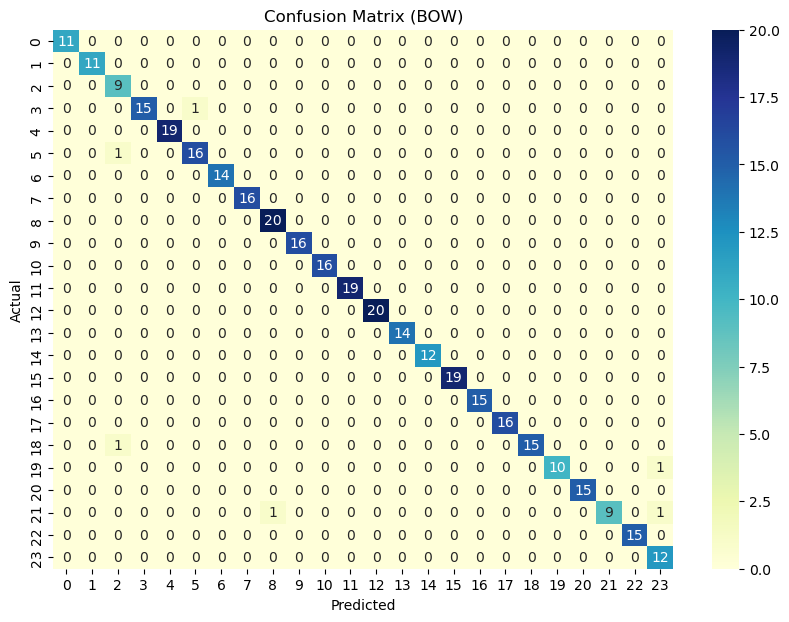

Confusion Matrix (BOW):
[[11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0]
 

In [127]:

# BOW Vectorization
try:
    count_vect = CountVectorizer()
    features1 = count_vect.fit_transform(data.Text_Final).toarray()
    labels = data.label
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features1, labels, data.index, test_size=0.3, random_state=72)
    model2 = LogisticRegression(solver='liblinear', random_state=0, tol=1e-5, verbose=1, max_iter=10000)
    clf2 = model2.fit(X_train, y_train)
    y_pred2 = model2.predict(X_test)
except Exception as e:
    raise RuntimeError("Error during BOW model training or prediction: " + str(e))

# Confusion Matrix and Accuracy for BOW
try:
    conf_mat2 = confusion_matrix(y_test, y_pred2)
    plt.figure(figsize=(10,7))
    sns.heatmap(conf_mat2, annot=True, fmt='d', cmap='YlGnBu', xticklabels=range(len(set(labels))), yticklabels=range(len(set(labels))))
    plt.title('Confusion Matrix (BOW)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print('Confusion Matrix (BOW):')
    print(conf_mat2)
    print('Accuracy Score (BOW):', accuracy_score(y_test, y_pred2))
except Exception as e:
    raise RuntimeError("Error during BOW confusion matrix or accuracy score calculation: " + str(e))


[LibLinear]iter  1 act 4.719e+02 pre 4.180e+02 delta 1.622e+00 f 6.654e+02 |g| 7.216e+02 CG   2
cg reaches trust region boundary
iter  2 act 9.892e+01 pre 8.184e+01 delta 2.164e+00 f 1.935e+02 |g| 1.672e+02 CG   3
cg reaches trust region boundary
iter  3 act 4.675e+01 pre 3.893e+01 delta 2.760e+00 f 9.462e+01 |g| 7.387e+01 CG   4
iter  4 act 1.073e+01 pre 9.121e+00 delta 2.760e+00 f 4.787e+01 |g| 2.642e+01 CG   4
iter  5 act 1.728e+00 pre 1.463e+00 delta 2.760e+00 f 3.714e+01 |g| 8.700e+00 CG   3
iter  6 act 2.644e-01 pre 2.445e-01 delta 2.760e+00 f 3.541e+01 |g| 2.236e+00 CG   4
iter  7 act 1.082e-02 pre 1.069e-02 delta 2.760e+00 f 3.515e+01 |g| 3.289e-01 CG   5
iter  8 act 4.233e-05 pre 4.232e-05 delta 2.760e+00 f 3.514e+01 |g| 1.686e-02 CG   5
iter  9 act 3.653e-07 pre 3.653e-07 delta 2.760e+00 f 3.514e+01 |g| 1.413e-03 CG   6
iter  1 act 4.842e+02 pre 4.283e+02 delta 1.623e+00 f 6.654e+02 |g| 7.337e+02 CG   2
cg reaches trust region boundary
iter  2 act 1.056e+02 pre 9.040e+01 delt

iter  9 act 2.876e-07 pre 2.876e-07 delta 2.333e+00 f 2.636e+01 |g| 1.338e-03 CG   5
iter  1 act 4.707e+02 pre 4.149e+02 delta 1.743e+00 f 6.654e+02 |g| 6.860e+02 CG   2
cg reaches trust region boundary
iter  2 act 1.099e+02 pre 9.167e+01 delta 2.353e+00 f 1.947e+02 |g| 1.591e+02 CG   3
iter  3 act 4.013e+01 pre 3.322e+01 delta 2.533e+00 f 8.480e+01 |g| 6.322e+01 CG   4
iter  4 act 8.772e+00 pre 7.455e+00 delta 2.533e+00 f 4.467e+01 |g| 2.316e+01 CG   4
iter  5 act 1.115e+00 pre 1.003e+00 delta 2.533e+00 f 3.590e+01 |g| 7.115e+00 CG   3
iter  6 act 7.201e-02 pre 7.052e-02 delta 2.533e+00 f 3.479e+01 |g| 1.361e+00 CG   5
iter  7 act 9.740e-04 pre 9.737e-04 delta 2.533e+00 f 3.472e+01 |g| 9.430e-02 CG   6
iter  8 act 4.359e-06 pre 4.358e-06 delta 2.533e+00 f 3.471e+01 |g| 5.996e-03 CG   6
iter  9 act 3.330e-08 pre 3.330e-08 delta 2.533e+00 f 3.471e+01 |g| 5.510e-04 CG   6
iter  1 act 4.907e+02 pre 4.303e+02 delta 1.818e+00 f 6.654e+02 |g| 6.883e+02 CG   2
cg reaches trust region boundary

iter  1 act 4.768e+02 pre 4.216e+02 delta 1.622e+00 f 6.654e+02 |g| 7.292e+02 CG   2
cg reaches trust region boundary
iter  2 act 1.029e+02 pre 8.680e+01 delta 2.104e+00 f 1.886e+02 |g| 1.732e+02 CG   2
iter  3 act 4.219e+01 pre 3.441e+01 delta 2.356e+00 f 8.567e+01 |g| 7.128e+01 CG   3
iter  4 act 1.068e+01 pre 8.948e+00 delta 2.356e+00 f 4.347e+01 |g| 2.566e+01 CG   3
iter  5 act 2.052e+00 pre 1.735e+00 delta 2.356e+00 f 3.279e+01 |g| 8.444e+00 CG   3
iter  6 act 3.591e-01 pre 3.183e-01 delta 2.356e+00 f 3.074e+01 |g| 2.386e+00 CG   4
iter  7 act 2.167e-02 pre 2.102e-02 delta 2.356e+00 f 3.038e+01 |g| 4.572e-01 CG   4
iter  8 act 2.816e-04 pre 2.815e-04 delta 2.356e+00 f 3.036e+01 |g| 4.278e-02 CG   5
iter  9 act 4.742e-07 pre 4.742e-07 delta 2.356e+00 f 3.036e+01 |g| 1.580e-03 CG   5
iter  1 act 4.626e+02 pre 4.116e+02 delta 1.494e+00 f 6.654e+02 |g| 7.271e+02 CG   2
cg reaches trust region boundary
iter  2 act 8.942e+01 pre 7.604e+01 delta 2.235e+00 f 2.028e+02 |g| 1.656e+02 CG   2

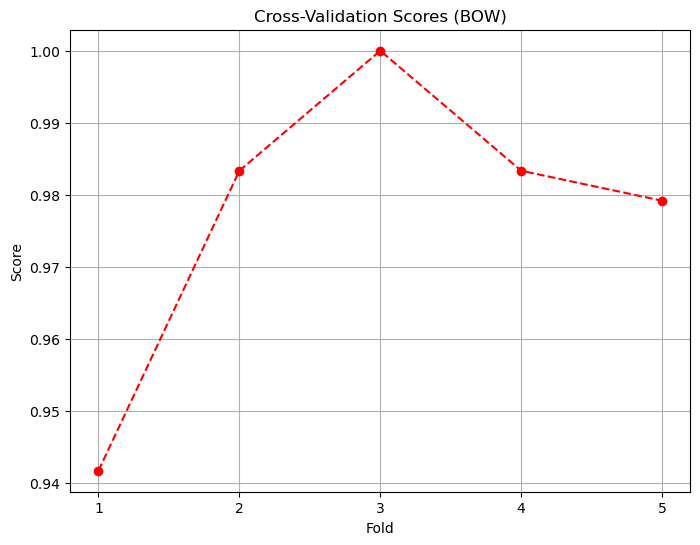

Cross-Validation Scores (BOW): [0.94166667 0.98333333 1.         0.98333333 0.97916667]
Mean Cross-Validation Score (BOW): 0.9775
AUC (BOW): 0.9997785156552739
Classification Report (BOW):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11
           2       0.82      1.00      0.90         9
           3       1.00      0.94      0.97        16
           4       1.00      1.00      1.00        19
           5       0.94      0.94      0.94        17
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00        16
           8       0.95      1.00      0.98        20
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        16
          11       1.00      1.00      1.00        19
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        14


In [128]:
# Cross-Validation for BOW
try:
    scores2 = cross_val_score(model2, features1, labels, cv=5)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 6), scores2, marker='o', linestyle='--', color='r')
    plt.title('Cross-Validation Scores (BOW)')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.xticks(range(1, 6))
    plt.grid(True)
    plt.show()
    print("Cross-Validation Scores (BOW):", scores2)
    print("Mean Cross-Validation Score (BOW):", scores2.mean())
except Exception as e:
    raise RuntimeError("Error during BOW cross-validation: " + str(e))

# ROC AUC Score for BOW
try:
    y_pred_proba2 = model2.predict_proba(X_test)
    print('AUC (BOW):', roc_auc_score(y_test, y_pred_proba2, multi_class='ovo'))
except Exception as e:
    raise RuntimeError("Error during BOW ROC AUC score calculation: " + str(e))

# Classification Report for BOW
try:
    print('Classification Report (BOW):')
    print(classification_report(y_test, y_pred2, zero_division=1))
except Exception as e:
    raise RuntimeError("Error during BOW classification report generation: " + str(e))